In [5]:
from losses.losses import TverskyLoss
from model.model import getModel
import sun_dataset.sun_dataset

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

model = getModel()

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
              loss=TverskyLoss(alpha=0.9835, smooth=2e4),
              metrics=['acc'])
model.load_weights('neuronalnet/saved_weights')

suns= tfds.load('sun_dataset')
PICTURE_SIZE = 224

@tf.autograph.experimental.do_not_convert
def load_images(datapoint):
  input_image = tf.image.resize(datapoint['image'], (PICTURE_SIZE, PICTURE_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (PICTURE_SIZE, PICTURE_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.math.round(tf.cast(input_mask, tf.float32) / 255.0)
  inverted_mask = tf.math.subtract(tf.ones((PICTURE_SIZE, PICTURE_SIZE, 1)), input_mask)

  return input_image, inverted_mask

def display(display_list):

  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

test = suns['test'].map(load_images).batch(1)

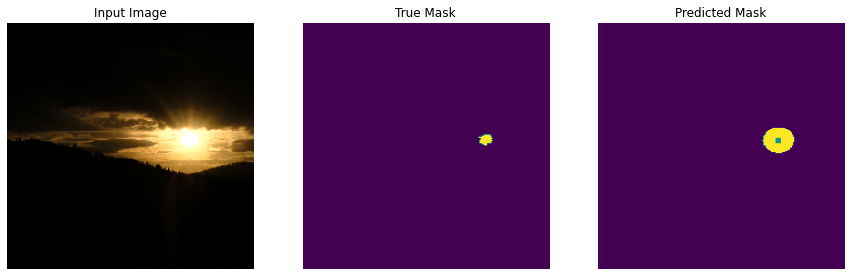

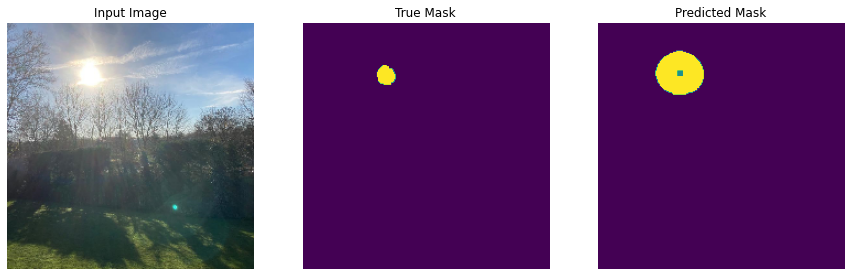

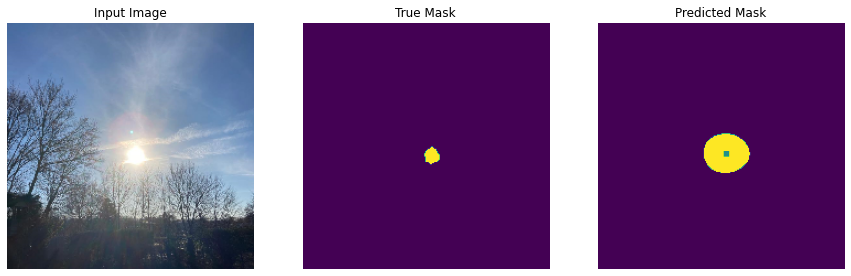

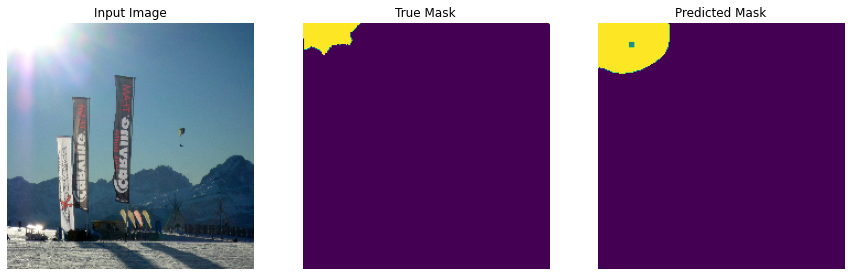

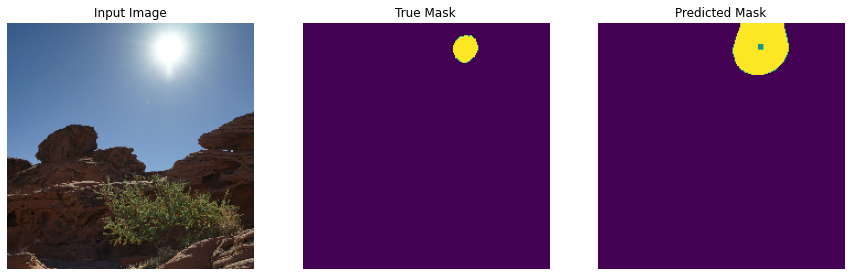

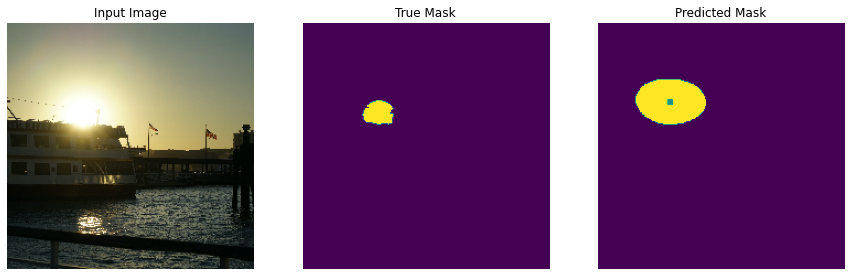

In [8]:
from scipy import ndimage

def center_of_mass(array):                        #input shape of numpy array [batch, x, y, dimension]
    center_x, center_y, pixels = 0,0,0
    for x in range(224):
        for y in range(224):
            if array[0][x][y][0]>0.75:
                center_x += x
                center_y += y
                pixels += 1
    return (center_x/pixels, center_y/pixels) 
                
for image, mask in test.take(6):
    pred = model.predict(image)                          #output shape [batch, x, y, dimension]
    pred = np.round(pred)
    
    center = center_of_mass(pred)

    center = np.round(center)
    for x in range(224):
        for y in range(224):
            if center[0]-3<x<center[0]+3 and center[1]-3<y<center[1]+3:
                pred[0][x][y][0]=0.5
    display([image[0], mask[0], pred[0]])
